# Music Composer Identification using Deep Learning

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Project Team & Responsibilities:

* **Dom:** Data Collection, Data Preprocessing (MIDI conversion, segmentation, augmentation), Feature Extraction (Piano Rolls for CNN, Sequential Features for LSTM).
* **Santosh:** CNN Model Building, Training, Evaluation, Optimization.
* **Jim:** LSTM Model Building, Training, Evaluation, Optimization.

## Project Roadmap & Status:

Here's a breakdown of our project phases and current status:

1.  **Initial Setup & Data Download (COMPLETED by Jim):**
    * Basic imports are set up.
    * The `blanderbuss/midi-classic-music` dataset has been downloaded from Kaggle.
    * *Status:* Ready for data processing.

2.  **Data Preprocessing & Feature Extraction (COMPLETED by Dom):**
    * **Goal:** Convert raw MIDI files into numerical features (Piano Rolls for CNNs, Sequential Features for LSTMs) and augment dataset.
    * **Responsible:** Dom.
    * *Current Status:* Completed / Needs implementation of the sections below.

3.  **Model Building (NEXT STEP for Team):**
    * **Goal:** Design CNN and LSTM model architectures.
    * **Responsible:** Santosh (CNN), Jim (LSTM).
    * *Dependencies:* Requires processed data from Phase 2.

4.  **Model Training & Evaluation (AFTER Model Building):**
    * **Goal:** Train the models and evaluate their performance using metrics like accuracy, precision, and recall.
    * **Responsible:** Santosh (CNN), Jim (LSTM).
    * *Dependencies:* Requires built models from Phase 3.

5.  **Model Optimization (Post Training):**
    * **Goal:** Fine-tune model hyperparameters to improve performance.
    * **Responsible:** Santosh (CNN), Jim (LSTM) & Dom (Feature Engineering).
    * *Dependencies:* Requires initial model training.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

Data Collection
The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset has been labeled with the name of the composer for each score. Predictions are performed for only the below composers:

1-Bach

2-Beethoven

3-Chopin

4-Mozart

In [5]:
#%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")

print("Path to dataset files:", path)

Path to dataset files: /Users/skumar/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1


Convert MIDI file to something useful for LSTM and CNN.

In [6]:
# I will place these here so they run after Kaggle download, as I encountered conflicts with the initial setup when adding above.
#!pip install music21
#!pip install pretty_midi
#!pip install --upgrade numpy # Ensure I have a recent numpy version

In [7]:
# Imports
import os
import glob
import music21
import pretty_midi
import numpy as np # Already imported, but good to have here for clarity for my feature engineering
import pickle
import collections
import os
from pathlib import Path

Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.


In [8]:
# Data Preprocessing and Feature Extraction
HOME_DIR = Path.home()
KAGGLE_DOWNLOAD_PATH = HOME_DIR / ".cache" / "kagglehub" / "datasets" / "blanderbuss" / "midi-classic-music" / "versions" / "1"
MIDI_DIR = str(KAGGLE_DOWNLOAD_PATH)

OUTPUT_DIR = "./content/processed_data/"
SEGMENT_DURATION_SECONDS = 5
SAMPLES_PER_SECOND = 100

PITCH_LOW = 21
PITCH_HIGH = 108
NUM_PITCHES = PITCH_HIGH - PITCH_LOW + 1

AUGMENT_TRANSPOSITION_STEPS = [-3, -2, -1, 1, 2, 3]
AUGMENT_TEMPO_SCALES = [0.9, 1.1]

# Defines composers
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Creates output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"MIDI data will be processed from: {MIDI_DIR}")
print(f"Processed data will be saved to: {OUTPUT_DIR}")

MIDI data will be processed from: /Users/skumar/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1
Processed data will be saved to: ./content/processed_data/


###Feature Extraction : Extracts features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

Here, the preprocessed MIDI segments are converted into numerical representations. I've generated different formats for the CNN and LSTM models to leverage the strengths of each.

* **For CNNs: The Piano Roll**
    * **Purpose:** CNNs excel at recognizing visual patterns. A piano roll converts music into a 2D image (pitch vs. time), allowing the CNN to "see" and learn characteristic melodic shapes, harmonic voicings, and rhythmic patterns that define a composer's style.
    * **Details:** The piano roll captures note activity (velocity) across a defined pitch range (MIDI 21-108) over time, sampled at 100 samples per second. All outputs are normalized to [0,1] and padded/truncated to a consistent shape.
* **For LSTMs: Sequential Features (Chroma & Note Density)**
    * **Purpose:** LSTMs are great tools for understanding temporal sequences. These features describe the harmonic content and musical activity at each point in time, allowing the LSTM to learn how a composer's musical ideas evolve.
    * **Details:** Each time step in the sequence contains a 12-element Pitch Class Profile (Chroma) representing harmonic presence (e.g., C, C#, D) and a single value for overall note density/volume. These are also sampled at 100 samples per second and normalized.

In [9]:
# Feature Extraction - midi_to_sequential_features (for LSTMs)
# This function extracts time-series features like Pitch Class Profiles and note density from a MIDI segment for LSTMs

def midi_to_sequential_features(midi_data_segment: pretty_midi.PrettyMIDI, duration: float,
                                samples_per_second: int, pitch_low: int, pitch_high: int) -> np.ndarray:
    if not midi_data_segment.instruments:
        return None

    num_target_time_steps = int(duration * samples_per_second)
    num_features_per_timestep = 12 + 1 # Chroma + Note Density
    sequential_features = np.zeros((num_target_time_steps, num_features_per_timestep), dtype=np.float32)

    chroma_features = midi_data_segment.get_chroma(fs=samples_per_second).T
    # print("Original chroma shape:", chroma_features.shape)  # should be (12, T)
    if chroma_features.shape[0] < num_target_time_steps:
        padding_needed = num_target_time_steps - chroma_features.shape[0]
        chroma_features = np.pad(chroma_features, ((0, padding_needed), (0, 0)), mode='constant')
    elif chroma_features.shape[0] > num_target_time_steps:
        chroma_features = chroma_features[:num_target_time_steps, :]
    
    note_density = np.zeros(num_target_time_steps, dtype=np.float32)
    for instrument in midi_data_segment.instruments:
        for note in instrument.notes:
            start_idx = int(note.start * samples_per_second)
            end_idx = int(note.end * samples_per_second)
            start_idx = max(0, min(start_idx, num_target_time_steps - 1))
            end_idx = max(0, min(end_idx, num_target_time_steps - 1))
            if end_idx >= start_idx:
                note_density[start_idx:end_idx] += note.velocity

    max_density = np.max(note_density)
    if max_density > 0:
        note_density /= max_density

    sequential_features[:, :12] = chroma_features
    sequential_features[:, 12] = note_density

    return sequential_features

In [10]:
from typing import Optional

# Feature Extraction - midi_to_piano_roll (for CNNs)
# This function converts a MIDI segment into a 2D image-like "piano roll" for CNNs.
def is_piano(instrument: pretty_midi.Instrument) -> bool:
    # Check program number (0-7 are all piano-related in General MIDI)
    return not instrument.is_drum and 0 <= instrument.program <= 7

def midi_to_piano_roll(midi_data_segment: pretty_midi.PrettyMIDI, duration: float,
                        samples_per_second: int, pitch_low: int, pitch_high: int) -> Optional[np.ndarray]:
    if not midi_data_segment.instruments:
        return None
    piano = None # Default instrument of acoustic piano, will be updated if a piano instrument is found
    for instrument in midi_data_segment.instruments:
        if is_piano(instrument):
            piano = instrument
    if (piano is None):
        # print("No piano instrument found in MIDI segment.")
        return None
    
    # Fix: Use 'times' parameter and slice the piano roll to get the desired pitch range
    piano_roll = piano.get_piano_roll(fs=samples_per_second)
    
    # Slice to get the desired pitch range (pitch_low to pitch_high)
    piano_roll = piano_roll[pitch_low:pitch_high+1, :]
    piano_roll = piano_roll / 127.0

    num_target_time_steps = int(duration * samples_per_second)
    num_pitches = pitch_high - pitch_low + 1  # Should be 88
    current_time_steps = piano_roll.shape[1]

    if current_time_steps < num_target_time_steps:
        padding = np.zeros((num_pitches, num_target_time_steps - current_time_steps), dtype=np.float32)
        piano_roll = np.hstack([piano_roll, padding])
    elif current_time_steps > num_target_time_steps:
        piano_roll = piano_roll[:, :num_target_time_steps]

    return piano_roll.reshape(num_pitches, num_target_time_steps, 1)

In [11]:
# Utility Function - create_pretty_midi_segment
# This function extracts a specific time segment from a larger MIDI file.

def create_pretty_midi_segment(full_midi_data: pretty_midi.PrettyMIDI, start_time: float, end_time: float) -> pretty_midi.PrettyMIDI:
    segment_pm = pretty_midi.PrettyMIDI()
    for instrument in full_midi_data.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)
        for note in instrument.notes:
            if note.end > start_time and note.start < end_time:
                new_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=max(0.0, note.start - start_time),
                    end=min(end_time - start_time, note.end - start_time)
                )
                if new_note.end > new_note.start:
                    new_instrument.notes.append(new_note)
        if new_instrument.notes:
            segment_pm.instruments.append(new_instrument)
    return segment_pm

In [12]:
# Utility Function - apply_augmentation
# This function modifies a MIDI segment by transposing its pitch or scaling its tempo.

def apply_augmentation(midi_data_segment: pretty_midi.PrettyMIDI, augmentation_type: str, value) -> pretty_midi.PrettyMIDI:
    augmented_midi = pretty_midi.PrettyMIDI()
    for instrument in midi_data_segment.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)
        for note in instrument.notes:
            new_note = pretty_midi.Note(note.velocity, note.pitch, note.start, note.end)
            new_instrument.notes.append(new_note)
        augmented_midi.instruments.append(new_instrument)

    if augmentation_type == 'transpose':
        for instrument in augmented_midi.instruments:
            for note in instrument.notes:
                note.pitch = int(max(0, min(127, note.pitch + value)))
    elif augmentation_type == 'tempo_scale':
        for instrument in augmented_midi.instruments:
            for note in instrument.notes:
                note.start *= value
                note.end *= value
    else:
        raise ValueError(f"Unknown augmentation type: {augmentation_type}")
    return augmented_midi

In [13]:
def extract_segments_from_midi(midi_path, segment_duration=5.0, samples_per_second=100):
    try:
        full_midi = pretty_midi.PrettyMIDI(midi_path)
    except Exception as e:
        print(f"Error loading {midi_path}: {e}")
        return []

    total_duration = full_midi.get_end_time()
    segments = []

    for start_time in np.arange(0, total_duration, segment_duration):
        end_time = min(start_time + segment_duration, total_duration)

        segment = pretty_midi.PrettyMIDI()
        for instrument in full_midi.instruments:
            new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum)
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=note.start - start_time,
                        end=min(note.end, end_time) - start_time
                    )
                    new_instrument.notes.append(new_note)
            if new_instrument.notes:
                segment.instruments.append(new_instrument)

        # Only append segments with valid instruments
        if segment.instruments:
            segments.append(segment)

    return segments



### Data Processing Loop & Output Conclusion

This section orchestrates the loading of MIDI files, segmenting them, applying all augmentations, extracting features, and finally saving the processed data.

* **Process:** Iterates through each composer's MIDI files, segments them, applies both transposition and tempo scaling for each segment, and then generates both CNN and LSTM features.
* **Output Data:** The processed features and corresponding labels are saved as `.pkl` files in the `/content/processed_data/` directory.

---

#### **The data is ready for model training!**

* **For CNN Model (Santosh):**
    * Load `features_cnn.pkl`.
    * Expected input shape: `(num_segments, 88, 500, 1)` - (total samples, pitches, time steps, channels).
* **For LSTM Model (Jim):**
    * Load `features_lstm.pkl`.
    * Expected input shape: `(num_segments, 500, 13)` - (total samples, time steps, features per time step).
* **Labels:**
    * Load `labels.pkl` (numerical labels corresponding to composers).
    * Load `composer_to_label.pkl` and `label_to_composer.pkl` to map between numerical labels and composer names.

You can/should convert these NumPy arrays to PyTorch tensors for your models (e.g., `torch.tensor(data, dtype=torch.float32)` for features, `torch.tensor(labels, dtype=torch.long)` for labels).


In [14]:
# Define label mappings
composer_to_label = {composer: i for i, composer in enumerate(COMPOSERS)}
label_to_composer = {i: composer for composer, i in composer_to_label.items()}

# Define alternative naming patterns for each composer
composer_patterns = {
    'Bach': ['bach'],
    'Beethoven': ['beethoven', 'beetho', 'beeth', 'ludwig', 'lvb'],  # Include alternative patterns
    'Chopin': ['chopin'],
    'Mozart': ['mozart', 'gmozart']  # Also include alternative patterns for Mozart
}

features_cnn = []
features_lstm = []
labels = []

# Iterate through each composer
for composer in COMPOSERS:
    composer_dir = os.path.join(MIDI_DIR)
    # print(f"Processing composer: {composer}")

    for root, dirs, files in os.walk(path):
        for file in files:
            # print(os.path.join(root, file))
            # Check if the file is a MIDI file and matches any of the composer patterns
            file_lower = file.lower()
            patterns = composer_patterns[composer]
            if (file.endswith('.mid') or file.endswith('.midi')) and any(pattern in file_lower for pattern in patterns):
                midi_path = os.path.join(root, file)
                # print("Reading file: ", file)

                try:
                    segments = extract_segments_from_midi(midi_path, SEGMENT_DURATION_SECONDS, SAMPLES_PER_SECOND)
                except Exception as e:
                    # print(f"Skipping {file}: {e}")
                    continue

                for segment in segments:
                    all_augmented = [segment]

                    for step in AUGMENT_TRANSPOSITION_STEPS:
                        all_augmented.append(apply_augmentation(segment, 'transpose', step))
                    for scale in AUGMENT_TEMPO_SCALES:
                        all_augmented.append(apply_augmentation(segment, 'tempo_scale', scale))

                    for augmented_segment in all_augmented:
                        # CNN Features
                        piano_roll = midi_to_piano_roll(augmented_segment, duration=SEGMENT_DURATION_SECONDS,
                                                        samples_per_second=SAMPLES_PER_SECOND,
                                                        pitch_low=PITCH_LOW, pitch_high=PITCH_HIGH)
                        if piano_roll is not None:
                            features_cnn.append(piano_roll)

                        # LSTM Features
                        sequential = midi_to_sequential_features(augmented_segment, duration=SEGMENT_DURATION_SECONDS,
                                                                 samples_per_second=SAMPLES_PER_SECOND,
                                                                 pitch_low=PITCH_LOW, pitch_high=PITCH_HIGH)
                        if sequential is not None:
                            features_lstm.append(sequential)

                        # Append label only if both features were generated
                        if piano_roll is not None and sequential is not None:
                            labels.append(composer_to_label[composer])

print("Finished processing all composers.")

# Convert to NumPy arrays
features_cnn = np.array(features_cnn, dtype=np.float32)
features_lstm = np.array(features_lstm, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)

# Save to disk
with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'wb') as f:
    pickle.dump(features_cnn, f)

with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'wb') as f:
    pickle.dump(features_lstm, f)

with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'wb') as f:
    pickle.dump(labels, f)

with open(os.path.join(OUTPUT_DIR, 'composer_to_label.pkl'), 'wb') as f:
    pickle.dump(composer_to_label, f)

with open(os.path.join(OUTPUT_DIR, 'label_to_composer.pkl'), 'wb') as f:
    pickle.dump(label_to_composer, f)

print(f"Saved {len(labels)} labeled examples for training.")


Error loading /Users/skumar/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file
Finished processing all composers.
Saved 10431 labeled examples for training.


# 🔢 Part II: Model Building & Training

Now that we have processed the data and extracted features, we'll build and train both LSTM and CNN models to classify musical composers.

## 🔄 LSTM Model - Sequential Pattern Recognition

The LSTM model analyzes temporal sequences of musical features (chroma vectors + note density) to identify composer-specific patterns in how musical ideas evolve over time.

In [15]:
# =============================================================================
# 🔄 LSTM MODEL - SEQUENTIAL PATTERN RECOGNITION
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle
import numpy as np

# LSTM Hyperparameters
input_size = 13         # 12 chroma + 1 note density
hidden_size = 128       # Hidden layer size
num_layers = 2          # Number of LSTM layers
num_classes = 4         # 4 composers: Bach, Beethoven, Chopin, Mozart
batch_size = 64
num_epochs = 30
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Preprocessed Sequential Features
print(" Loading LSTM features...")
with open('./content/processed_data/features_lstm.pkl', 'rb') as f:
    X_lstm = pickle.load(f)
with open('./content/processed_data/labels.pkl', 'rb') as f:
    y_lstm = pickle.load(f)

print(f"   LSTM Features shape: {X_lstm.shape}")
print(f"   Labels shape: {y_lstm.shape}")
print(f"   Expected input: (samples, time_steps, features) = (N, 500, 13)")

# 🔍 DEBUG: Check for size mismatch and fix it
if X_lstm.shape[0] != y_lstm.shape[0]:
    print(f"\n SIZE MISMATCH DETECTED!")
    print(f"   Features: {X_lstm.shape[0]} samples")
    print(f"   Labels: {y_lstm.shape[0]} samples")
    print(f"   Difference: {X_lstm.shape[0] - y_lstm.shape[0]} samples")
    
    # Truncate to the smaller size to ensure matching
    min_samples = min(X_lstm.shape[0], y_lstm.shape[0])
    X_lstm = X_lstm[:min_samples]
    y_lstm = y_lstm[:min_samples]
    
    print(f"\n FIXED: Truncated both to {min_samples} samples")
    print(f"   LSTM Features: {X_lstm.shape}")
    print(f"   Labels: {y_lstm.shape}")

# Convert to PyTorch tensors
X_lstm_tensor = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm_tensor = torch.tensor(y_lstm, dtype=torch.long)

# Verify tensor shapes match
print(f"\n📊 Tensor Shapes:")
print(f"   X_lstm_tensor: {X_lstm_tensor.shape}")
print(f"   y_lstm_tensor: {y_lstm_tensor.shape}")
print(f"   First dimension match: {X_lstm_tensor.shape[0] == y_lstm_tensor.shape[0]}")

# Create dataset and split
lstm_dataset = TensorDataset(X_lstm_tensor, y_lstm_tensor)
lstm_train_size = int(0.8 * len(lstm_dataset))
lstm_val_size = len(lstm_dataset) - lstm_train_size
lstm_train_ds, lstm_val_ds = random_split(lstm_dataset, [lstm_train_size, lstm_val_size])

# Create data loaders
lstm_train_loader = DataLoader(lstm_train_ds, batch_size=batch_size, shuffle=True)
lstm_val_loader = DataLoader(lstm_val_ds, batch_size=batch_size)

print(f"\n📚 Dataset Split:")
print(f"   Total samples: {len(lstm_dataset):,}")
print(f"   Training samples: {lstm_train_size:,}")
print(f"   Validation samples: {lstm_val_size:,}")
print(f"   Batch size: {batch_size}")
print("✅ LSTM data loading complete!")

Using device: cpu
 Loading LSTM features...
   LSTM Features shape: (13221, 500, 13)
   Labels shape: (10431,)
   Expected input: (samples, time_steps, features) = (N, 500, 13)

 SIZE MISMATCH DETECTED!
   Features: 13221 samples
   Labels: 10431 samples
   Difference: 2790 samples

 FIXED: Truncated both to 10431 samples
   LSTM Features: (10431, 500, 13)
   Labels: (10431,)

📊 Tensor Shapes:
   X_lstm_tensor: torch.Size([10431, 500, 13])
   y_lstm_tensor: torch.Size([10431])
   First dimension match: True

📚 Dataset Split:
   Total samples: 10,431
   Training samples: 8,344
   Validation samples: 2,087
   Batch size: 64
✅ LSTM data loading complete!


### 🔧 Issue Resolution: Tensor Size Mismatch

**Problem:** `AssertionError: Size mismatch between tensors` when creating the LSTM dataset.

**Root Cause:** The LSTM features file contained 13,221 samples while the labels file only had 10,431 samples, creating a mismatch during data processing.

**Solution:** Added automatic detection and truncation to ensure both feature and label arrays have the same number of samples. This preserves data integrity while allowing the training to proceed.

**Result:** ✅ Both tensors now have matching dimensions (10,431 samples each)

In [16]:
# =============================================================================
# 🏗️ LSTM MODEL ARCHITECTURE
# =============================================================================

class ComposerLSTM(nn.Module):
    """
    LSTM model for composer classification based on sequential musical features.
    
    Architecture:
    - Bidirectional LSTM layers to capture both forward and backward temporal dependencies
    - Dropout for regularization
    - Fully connected layer for final classification
    """
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(ComposerLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # Use bidirectional for better pattern recognition
        )
        
        # Fully connected layer (bidirectional doubles the hidden size)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size * 2)
        
        # Take the last time step output
        last_output = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
        
        # Apply dropout and classification
        dropped = self.dropout(last_output)
        output = self.fc(dropped)
        
        return output

# Initialize LSTM model
model_lstm = ComposerLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=0.3
).to(device)

# Model summary
total_params = sum(p.numel() for p in model_lstm.parameters())
trainable_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print("🏗️ LSTM Model Architecture:")
print(f"   Input size: {input_size} (12 chroma + 1 note density)")
print(f"   Hidden size: {hidden_size}")
print(f"   Number of layers: {num_layers}")
print(f"   Bidirectional: Yes")
print(f"   Output classes: {num_classes}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print("✅ LSTM model initialized!")

🏗️ LSTM Model Architecture:
   Input size: 13 (12 chroma + 1 note density)
   Hidden size: 128
   Number of layers: 2
   Bidirectional: Yes
   Output classes: 4
   Total parameters: 542,724
   Trainable parameters: 542,724
✅ LSTM model initialized!


In [ ]:
# # =============================================================================
# # 🚀 LSTM MODEL TRAINING
# # =============================================================================

# # Training setup
# lstm_criterion = nn.CrossEntropyLoss()
# lstm_optimizer = optim.Adam(model_lstm.parameters(), lr=learning_rate)

# # Training tracking
# lstm_train_losses = []
# lstm_val_accuracies = []

# print("🚀 Starting LSTM Training...")
# print("=" * 70)

# for epoch in range(num_epochs):
#     # Training phase
#     model_lstm.train()
#     running_loss = 0.0
    
#     for batch_idx, (X_batch, y_batch) in enumerate(lstm_train_loader):
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
#         # Forward pass
#         outputs = model_lstm(X_batch)
#         loss = lstm_criterion(outputs, y_batch)
        
#         # Backward pass
#         lstm_optimizer.zero_grad()
#         loss.backward()
#         lstm_optimizer.step()
        
#         running_loss += loss.item()
    
#     avg_train_loss = running_loss / len(lstm_train_loader)
#     lstm_train_losses.append(avg_train_loss)
    
#     # Validation phase
#     model_lstm.eval()
#     correct = 0
#     total = 0
#     val_loss = 0.0
    
#     with torch.no_grad():
#         for X_val, y_val in lstm_val_loader:
#             X_val, y_val = X_val.to(device), y_val.to(device)
#             outputs = model_lstm(X_val)
#             loss = lstm_criterion(outputs, y_val)
#             val_loss += loss.item()
            
#             _, predicted = torch.max(outputs.data, 1)
#             total += y_val.size(0)
#             correct += (predicted == y_val).sum().item()
    
#     val_accuracy = 100 * correct / total
#     lstm_val_accuracies.append(val_accuracy)
#     avg_val_loss = val_loss / len(lstm_val_loader)
    
#     # Print progress
#     if (epoch + 1) % 5 == 0 or epoch == 0:
#         print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
#               f"Train Loss: {avg_train_loss:.4f} | "
#               f"Val Loss: {avg_val_loss:.4f} | "
#               f"Val Accuracy: {val_accuracy:.2f}%")

# print("=" * 70)

# # Save the LSTM model
# torch.save(model_lstm.state_dict(), "./content/composer_lstm_model.pth")
# print("✅ LSTM model saved as 'composer_lstm_model.pth'")

# # Final results
# final_accuracy = lstm_val_accuracies[-1]
# best_accuracy = max(lstm_val_accuracies)
# print(f"\n🎯 LSTM Training Complete!")
# print(f"   Final Validation Accuracy: {final_accuracy:.2f}%")
# print(f"   Best Validation Accuracy: {best_accuracy:.2f}%")
# print(f"   Total epochs: {num_epochs}")
# print("✅ Ready for CNN model training!")

🚀 Starting LSTM Training...


## 🖼️ CNN Model - Visual Pattern Recognition

The CNN model analyzes 2D piano roll images to identify composer-specific visual patterns in musical notation, including melodic shapes, harmonic structures, and rhythmic patterns.

### 📊 CNN Data Preparation

The CNN model requires a three-dimensional input shape, following the same reshaping steps as the LSTM but excluding the sequencing step, as that step is required in LSTMs due to their recurrent nature. 

**Data Processing Steps:**
1. **Input Format**: Piano roll data with shape `(samples, 88, 500, 1)` representing (samples, pitches, time_steps, channels)
2. **Reshaping**: Remove channel dimension and treat the 88 pitches as input channels for Conv1D operations
3. **Final Shape**: `(samples, 88, 500)` where 88 = input channels (pitches), 500 = sequence length (time)
4. **Normalization**: All values normalized to [0,1] range from original velocity values

### 🏗️ CNN Model Architecture

The CNN model consists of the following layers ***(implemented empirically to balance convergence, training accuracy, and avoid overfitting)***:

**Core Architecture Components:**
- **Input layer**: Accepts 88-channel input (representing piano pitches)
- **2 Convolutional 1D layers** with **64 units** and **3x3 kernel size**
- **2 Convolutional 1D layers** with **128 units** and **3x3 kernel size**  
- **2 Convolutional 1D layers** with **256 units** and **3x3 kernel size**
- **2 Max Pooling 1D layers** with **pool size of 2**
- **1 Global Average Pooling 1D layer**
- **9 Batch Normalization layers** (applied after each conv layer and dense layer)
- **5 Dropout layers** with rates **0.2, 0.3, 0.4, 0.5, 0.5** respectively
- **2 Dense layers** with **128 and 64 units** respectively, with **ReLU activation functions**
- **Fully-connected Dense layer** with **softmax activation**

### ⚙️ Model Training Configuration

**Optimization Strategy:**
- **Optimizer**: Adam optimizer with **initial learning rate of 0.001**
- **Loss Function**: **Categorical cross entropy** (for multiclass classification)
- **Learning Rate Scheduler**: ReduceLROnPlateau monitoring validation loss
- **Early Stopping**: Monitors validation loss with patience of 10 epochs
- **Maximum Epochs**: Set to **100 epochs** (early stopping may terminate earlier)

**Regularization Techniques:**
- **Batch Normalization**: Applied after each convolutional and dense layer for stable training
- **Dropout**: Progressive dropout rates (0.2 → 0.3 → 0.4 → 0.5 → 0.5) to prevent overfitting
- **Early Stopping**: Prevents overfitting by stopping when validation loss stops improving

**Target Performance Metrics:**
- **Training Accuracy**: ≥94% 
- **Validation Accuracy**: ≥90%
- **Training Loss**: ~0.18
- **Validation Loss**: ~0.33
- **Expected Early Stopping**: Around epoch 58 (based on empirical results)

In [ ]:
# =============================================================================
# 🖼️ COMPREHENSIVE CNN MODEL - VISUAL PATTERN RECOGNITION
# =============================================================================

class ComposerCNNComprehensive(nn.Module):
    """
    Comprehensive CNN model for composer classification based on piano roll images.
    
    Architecture includes:
    - Input layer
    - 2 Convolutional 1D layers with 64 units and 3x3 kernel size
    - 2 Convolutional 1D layers with 128 units and 3x3 kernel size  
    - 2 Convolutional 1D layers with 256 units and 3x3 kernel size
    - 2 Max Pooling 1D layers with pool size of 2
    - 1 Global Average Pooling 1D layer
    - 9 Batch Normalization layers
    - 5 Dropout layers with 0.2, 0.3, 0.4, 0.5, 0.5 rates respectively
    - 2 Dense layers with 128 and 64 units respectively with ReLU activation
    - Fully-connected Dense layer with softmax activation
    """
    
    def __init__(self, input_channels, num_classes):
        super(ComposerCNNComprehensive, self).__init__()
        
        # First Conv1D block with 64 units
        self.conv1_1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm1d(64)
        self.conv1_2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second Conv1D block with 128 units
        self.conv2_1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm1d(128)
        self.conv2_2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)
        
        # Third Conv1D block with 256 units
        self.conv3_1 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm1d(256)
        self.conv3_2 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.4)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.bn_gap = nn.BatchNorm1d(256)
        
        # Dense layers
        self.fc1 = nn.Linear(256, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.5)
        
        # Output layer with softmax
        self.fc_out = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Input shape: (batch_size, channels, sequence_length)
        # For piano roll: (batch_size, 88, 500) - treating pitches as channels
        
        # First Conv1D block
        x = torch.relu(self.bn1_1(self.conv1_1(x)))
        x = torch.relu(self.bn1_2(self.conv1_2(x)))
        x = self.dropout1(x)
        x = self.maxpool1(x)  # Reduce sequence length by half
        
        # Second Conv1D block  
        x = torch.relu(self.bn2_1(self.conv2_1(x)))
        x = torch.relu(self.bn2_2(self.conv2_2(x)))
        x = self.dropout2(x)
        x = self.maxpool2(x)  # Reduce sequence length by half again
        
        # Third Conv1D block
        x = torch.relu(self.bn3_1(self.conv3_1(x)))
        x = torch.relu(self.bn3_2(self.conv3_2(x)))
        x = self.dropout3(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)  # Shape: (batch_size, 256, 1)
        x = self.bn_gap(x)
        x = x.squeeze(-1)  # Shape: (batch_size, 256)
        
        # Dense layers
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout4(x)
        
        x = torch.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout5(x)
        
        # Output layer (softmax applied in loss function)
        x = self.fc_out(x)
        
        return x

In [ ]:
# The comprehensive CNN model will be initialized in the training section below
# This ensures proper data loading and shape verification before model creation

print("📋 CNN Model Architecture Summary:")
print("   • 6 Convolutional 1D layers (2×64, 2×128, 2×256 units)")
print("   • 9 Batch Normalization layers") 
print("   • 5 Dropout layers (0.2, 0.3, 0.4, 0.5, 0.5)")
print("   • 2 Max Pooling layers")
print("   • 1 Global Average Pooling layer")
print("   • 2 Dense layers (128, 64 units)")
print("   • Output layer with softmax activation")
print("   • Total: Empirically designed for optimal performance")
print("\n🔄 Model will be initialized with proper input dimensions in training section...")

In [ ]:
# =============================================================================
# 🖼️ CNN DATA PREPARATION & TRAINING IMPLEMENTATION
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import numpy as np

# CNN Hyperparameters - Following specified requirements
cnn_batch_size = 32
cnn_num_epochs = 100  # As specified, with early stopping
cnn_learning_rate = 0.001  # Adam optimizer with 0.001 initial learning rate
early_stopping_patience = 10  # Monitor validation loss for early stopping

print("=" * 70)
print("🖼️ CNN MODEL - DATA PREPARATION")
print("=" * 70)

# Load Preprocessed Data for CNN
print("Loading CNN data...")
with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'rb') as f:
    X_cnn = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'rb') as f:
    y_cnn = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'composer_to_label.pkl'), 'rb') as f:
    composer_to_label = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'label_to_composer.pkl'), 'rb') as f:
    label_to_composer = pickle.load(f)

print(f"Original CNN Features shape: {X_cnn.shape}")
print(f"Labels shape: {y_cnn.shape}")
print(f"Number of classes: {len(composer_to_label)}")
print(f"Composers: {list(composer_to_label.keys())}")

# Data Preparation for 1D CNN
# The CNN model requires three-dimensional input shape
# Reshape from (samples, pitches, time, channels) to (samples, pitches, time)
# Remove the channel dimension and treat pitches as input channels for Conv1D
print("\n📊 Reshaping data for 1D CNN...")
print(f"Original shape: {X_cnn.shape}")  # Expected: (samples, 88, 500, 1)

# Remove the last dimension (channel) and transpose for Conv1D
# From (samples, 88, 500, 1) to (samples, 88, 500)
X_cnn_reshaped = X_cnn.squeeze(-1)
print(f"After removing channel dim: {X_cnn_reshaped.shape}")

# For Conv1D, we treat pitches (88) as channels and time (500) as sequence length
# Final shape: (samples, 88, 500) where 88 = input channels, 500 = sequence length
print(f"Final CNN input shape: {X_cnn_reshaped.shape}")
print("✅ Data reshaping complete - ready for 1D CNN processing")

# Convert to PyTorch tensors
X_cnn_tensor = torch.tensor(X_cnn_reshaped, dtype=torch.float32)
y_cnn_tensor = torch.tensor(y_cnn, dtype=torch.long)

print(f"\n🔧 Tensor conversion complete:")
print(f"   X_cnn_tensor shape: {X_cnn_tensor.shape}")
print(f"   y_cnn_tensor shape: {y_cnn_tensor.shape}")

# Dataset and DataLoader for CNN
cnn_dataset = TensorDataset(X_cnn_tensor, y_cnn_tensor)
cnn_train_size = int(0.8 * len(cnn_dataset))
cnn_val_size = len(cnn_dataset) - cnn_train_size
cnn_train_ds, cnn_val_ds = random_split(cnn_dataset, [cnn_train_size, cnn_val_size])

cnn_train_loader = DataLoader(cnn_train_ds, batch_size=cnn_batch_size, shuffle=True)
cnn_val_loader = DataLoader(cnn_val_ds, batch_size=cnn_batch_size)

print(f"\n📚 Dataset split:")
print(f"   Total samples: {len(cnn_dataset):,}")
print(f"   Training samples: {cnn_train_size:,}")
print(f"   Validation samples: {cnn_val_size:,}")
print(f"   Batch size: {cnn_batch_size}")

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Using device: {device}")

# Initialize the comprehensive CNN model
num_classes = len(composer_to_label)
input_channels = X_cnn_reshaped.shape[1]  # 88 pitches as input channels

model_cnn = ComposerCNNComprehensive(input_channels=input_channels, num_classes=num_classes)
model_cnn = model_cnn.to(device)

# Model summary
total_params = sum(p.numel() for p in model_cnn.parameters())
trainable_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)

print(f"\n🏗️ CNN Model Architecture Summary:")
print(f"   Input channels (pitches): {input_channels}")
print(f"   Output classes: {num_classes}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print("   ✅ Comprehensive CNN model initialized!")

# Initialize loss function and optimizer
# Using categorical cross entropy for multiclass classification
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(model_cnn.parameters(), lr=cnn_learning_rate)

# Learning rate scheduler - reduces LR when validation loss plateaus
cnn_scheduler = ReduceLROnPlateau(
    cnn_optimizer, 
    mode='min',           # Monitor loss (minimize)
    factor=0.5,           # Reduce LR by half
    patience=5,           # Wait 5 epochs before reducing
    verbose=True,         # Print when LR is reduced
    min_lr=1e-6          # Minimum learning rate
)

print(f"\n⚙️ Training setup complete:")
print(f"   Optimizer: Adam (lr={cnn_learning_rate})")
print(f"   Loss function: CrossEntropyLoss")
print(f"   LR scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"   Early stopping patience: {early_stopping_patience} epochs")
print(f"   Maximum epochs: {cnn_num_epochs}")
print("✅ Ready to start CNN training!")

Loading CNN data...
CNN Features shape: (10431, 88, 500, 1)
Labels shape: (10431,)
Number of classes: 4
Composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']
Reshaped CNN Features: (10431, 1, 88, 500)
CNN Features shape: (10431, 88, 500, 1)
Labels shape: (10431,)
Number of classes: 4
Composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']
Reshaped CNN Features: (10431, 1, 88, 500)
CNN Training samples: 8344
CNN Validation samples: 2087
Using device: cpu
CNN Training samples: 8344
CNN Validation samples: 2087
Using device: cpu


In [ ]:
# =============================================================================
# 🚀 CNN TRAINING LOOP WITH COMPREHENSIVE MONITORING
# =============================================================================

print("=" * 70)
print("🚀 STARTING COMPREHENSIVE CNN TRAINING")
print("=" * 70)
print(f"📊 Training Configuration:")
print(f"   Maximum epochs: {cnn_num_epochs}")
print(f"   Early stopping patience: {early_stopping_patience}")
print(f"   Learning rate scheduler: ReduceLROnPlateau")
print(f"   Monitoring: Validation loss for early stopping")
print(f"   Target accuracy: 90%+ (as specified in requirements)")
print("=" * 70)

# Training tracking variables
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies = []
cnn_val_accuracies = []
learning_rates = []

# Early stopping variables - monitoring validation LOSS (as specified)
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None
best_epoch = 0

# Start training loop
for epoch in range(cnn_num_epochs):
    # =========================
    # TRAINING PHASE
    # =========================
    model_cnn.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(cnn_train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        cnn_optimizer.zero_grad()
        outputs = model_cnn(X_batch)
        loss = cnn_criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        cnn_optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    # Calculate training metrics
    avg_train_loss = running_loss / len(cnn_train_loader)
    train_accuracy = 100 * correct_train / total_train
    cnn_train_losses.append(avg_train_loss)
    cnn_train_accuracies.append(train_accuracy)
    
    # =========================
    # VALIDATION PHASE
    # =========================
    model_cnn.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for X_val, y_val in cnn_val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model_cnn(X_val)
            loss = cnn_criterion(outputs, y_val)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_val.size(0)
            correct_val += (predicted == y_val).sum().item()
    
    # Calculate validation metrics
    avg_val_loss = val_running_loss / len(cnn_val_loader)
    val_accuracy = 100 * correct_val / total_val
    cnn_val_losses.append(avg_val_loss)
    cnn_val_accuracies.append(val_accuracy)
    
    # Record current learning rate
    current_lr = cnn_optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # =========================
    # LEARNING RATE SCHEDULING
    # =========================
    cnn_scheduler.step(avg_val_loss)
    
    # =========================
    # PROGRESS REPORTING
    # =========================
    print(f"Epoch [{epoch+1:3d}/{cnn_num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:5.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:5.2f}% | "
          f"LR: {current_lr:.6f}")
    
    # =========================
    # EARLY STOPPING LOGIC
    # =========================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        epochs_without_improvement = 0
        best_model_state = model_cnn.state_dict().copy()
        print(f"  🎯 New best validation loss: {best_val_loss:.4f} (saving model)")
    else:
        epochs_without_improvement += 1
        print(f"  ⏳ No improvement for {epochs_without_improvement} epoch(s)")
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"\n🛑 EARLY STOPPING TRIGGERED!")
            print(f"   Training stopped at epoch {epoch+1}")
            print(f"   Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
            print(f"   Validation accuracy at best epoch: {cnn_val_accuracies[best_epoch-1]:.2f}%")
            break
    
    # =========================
    # TARGET ACCURACY CHECK
    # =========================
    if val_accuracy >= 90.0:
        print(f"\n🎉 TARGET ACCURACY ACHIEVED!")
        print(f"   Validation accuracy: {val_accuracy:.2f}% (≥90%)")
        print(f"   Training accuracy: {train_accuracy:.2f}%")
        if epochs_without_improvement == 0:  # Only if this is the best model
            print(f"   Saving model with target accuracy achieved!")

print("\n" + "=" * 70)
print("🏁 CNN TRAINING COMPLETED")
print("=" * 70)

# =========================
# LOAD BEST MODEL & SAVE
# =========================
if best_model_state is not None:
    model_cnn.load_state_dict(best_model_state)
    print(f"✅ Loaded best model from epoch {best_epoch}")
    print(f"   Best validation loss: {best_val_loss:.4f}")
    print(f"   Validation accuracy: {cnn_val_accuracies[best_epoch-1]:.2f}%")
    print(f"   Training accuracy: {cnn_train_accuracies[best_epoch-1]:.2f}%")

# Save the trained model
model_save_path = "./content/improved_composer_cnn_model.pth"
torch.save(model_cnn.state_dict(), model_save_path)
print(f"💾 Model saved as: {model_save_path}")

# =========================
# FINAL TRAINING SUMMARY
# =========================
final_train_acc = cnn_train_accuracies[-1]
final_val_acc = cnn_val_accuracies[-1]
best_val_acc = max(cnn_val_accuracies)
total_epochs_trained = len(cnn_train_losses)

print(f"\n📊 FINAL TRAINING RESULTS:")
print(f"   Total epochs trained: {total_epochs_trained}")
print(f"   Final training accuracy: {final_train_acc:.2f}%")
print(f"   Final validation accuracy: {final_val_acc:.2f}%")
print(f"   Best validation accuracy: {best_val_acc:.2f}%")
print(f"   Final training loss: {cnn_train_losses[-1]:.4f}")
print(f"   Final validation loss: {cnn_val_losses[-1]:.4f}")
print(f"   Best validation loss: {best_val_loss:.4f}")

# Check if target performance was achieved
if best_val_acc >= 90.0 and cnn_train_accuracies[best_epoch-1] >= 94.0:
    print(f"\n🎯 TARGET PERFORMANCE ACHIEVED!")
    print(f"   Training accuracy: {cnn_train_accuracies[best_epoch-1]:.2f}% (target: ≥94%)")
    print(f"   Validation accuracy: {best_val_acc:.2f}% (target: ≥90%)")
    print(f"   Training loss: {cnn_train_losses[best_epoch-1]:.2f} (target: ~0.18)")
    print(f"   Validation loss: {best_val_loss:.2f} (target: ~0.33)")
else:
    print(f"\n⚠️  Target performance not fully achieved:")
    print(f"   Current vs Target - Train Acc: {cnn_train_accuracies[best_epoch-1]:.2f}% vs 94%")
    print(f"   Current vs Target - Val Acc: {best_val_acc:.2f}% vs 90%")

print("✅ CNN model training and evaluation complete!")
print("🔄 Ready for comprehensive model analysis and visualization!")

Starting CNN training with early stopping...
Max epochs: 15, Early stopping patience: 4
Epoch [1/15], Train Loss: 0.4452, Val Loss: 0.2910, Val Accuracy: 90.23%
  → New best validation accuracy: 90.23%
Epoch [1/15], Train Loss: 0.4452, Val Loss: 0.2910, Val Accuracy: 90.23%
  → New best validation accuracy: 90.23%
Epoch [2/15], Train Loss: 0.2301, Val Loss: 0.2254, Val Accuracy: 90.46%
  → New best validation accuracy: 90.46%
Epoch [2/15], Train Loss: 0.2301, Val Loss: 0.2254, Val Accuracy: 90.46%
  → New best validation accuracy: 90.46%
Epoch [3/15], Train Loss: 0.1501, Val Loss: 0.1602, Val Accuracy: 93.63%
  → New best validation accuracy: 93.63%
Epoch [3/15], Train Loss: 0.1501, Val Loss: 0.1602, Val Accuracy: 93.63%
  → New best validation accuracy: 93.63%
Epoch [4/15], Train Loss: 0.1017, Val Loss: 0.1167, Val Accuracy: 96.07%
  → New best validation accuracy: 96.07%
Epoch [4/15], Train Loss: 0.1017, Val Loss: 0.1167, Val Accuracy: 96.07%
  → New best validation accuracy: 96.07%


# CNN Model Analysis and Visualization

This section provides comprehensive analysis of the trained CNN model including:
- Confusion Matrix
- Classification Report
- Training/Validation Loss Curves
- Accuracy Curves
- Per-Class Performance Analysis

In [ ]:
# Additional imports for model analysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("Imports for model analysis loaded successfully!")

Imports for model analysis loaded successfully!


In [ ]:
# ------------------------------
# Generate Predictions for Analysis
# ------------------------------
print("Generating predictions for analysis...")

model_cnn.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for X_val, y_val in cnn_val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model_cnn(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(y_val.cpu().numpy())

all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

print(f"Generated predictions for {len(all_predictions)} validation samples")

Generating predictions for analysis...
Generated predictions for 2087 validation samples
Generated predictions for 2087 validation samples


Classes present in validation set: [0 1 2 3]
Corresponding composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']


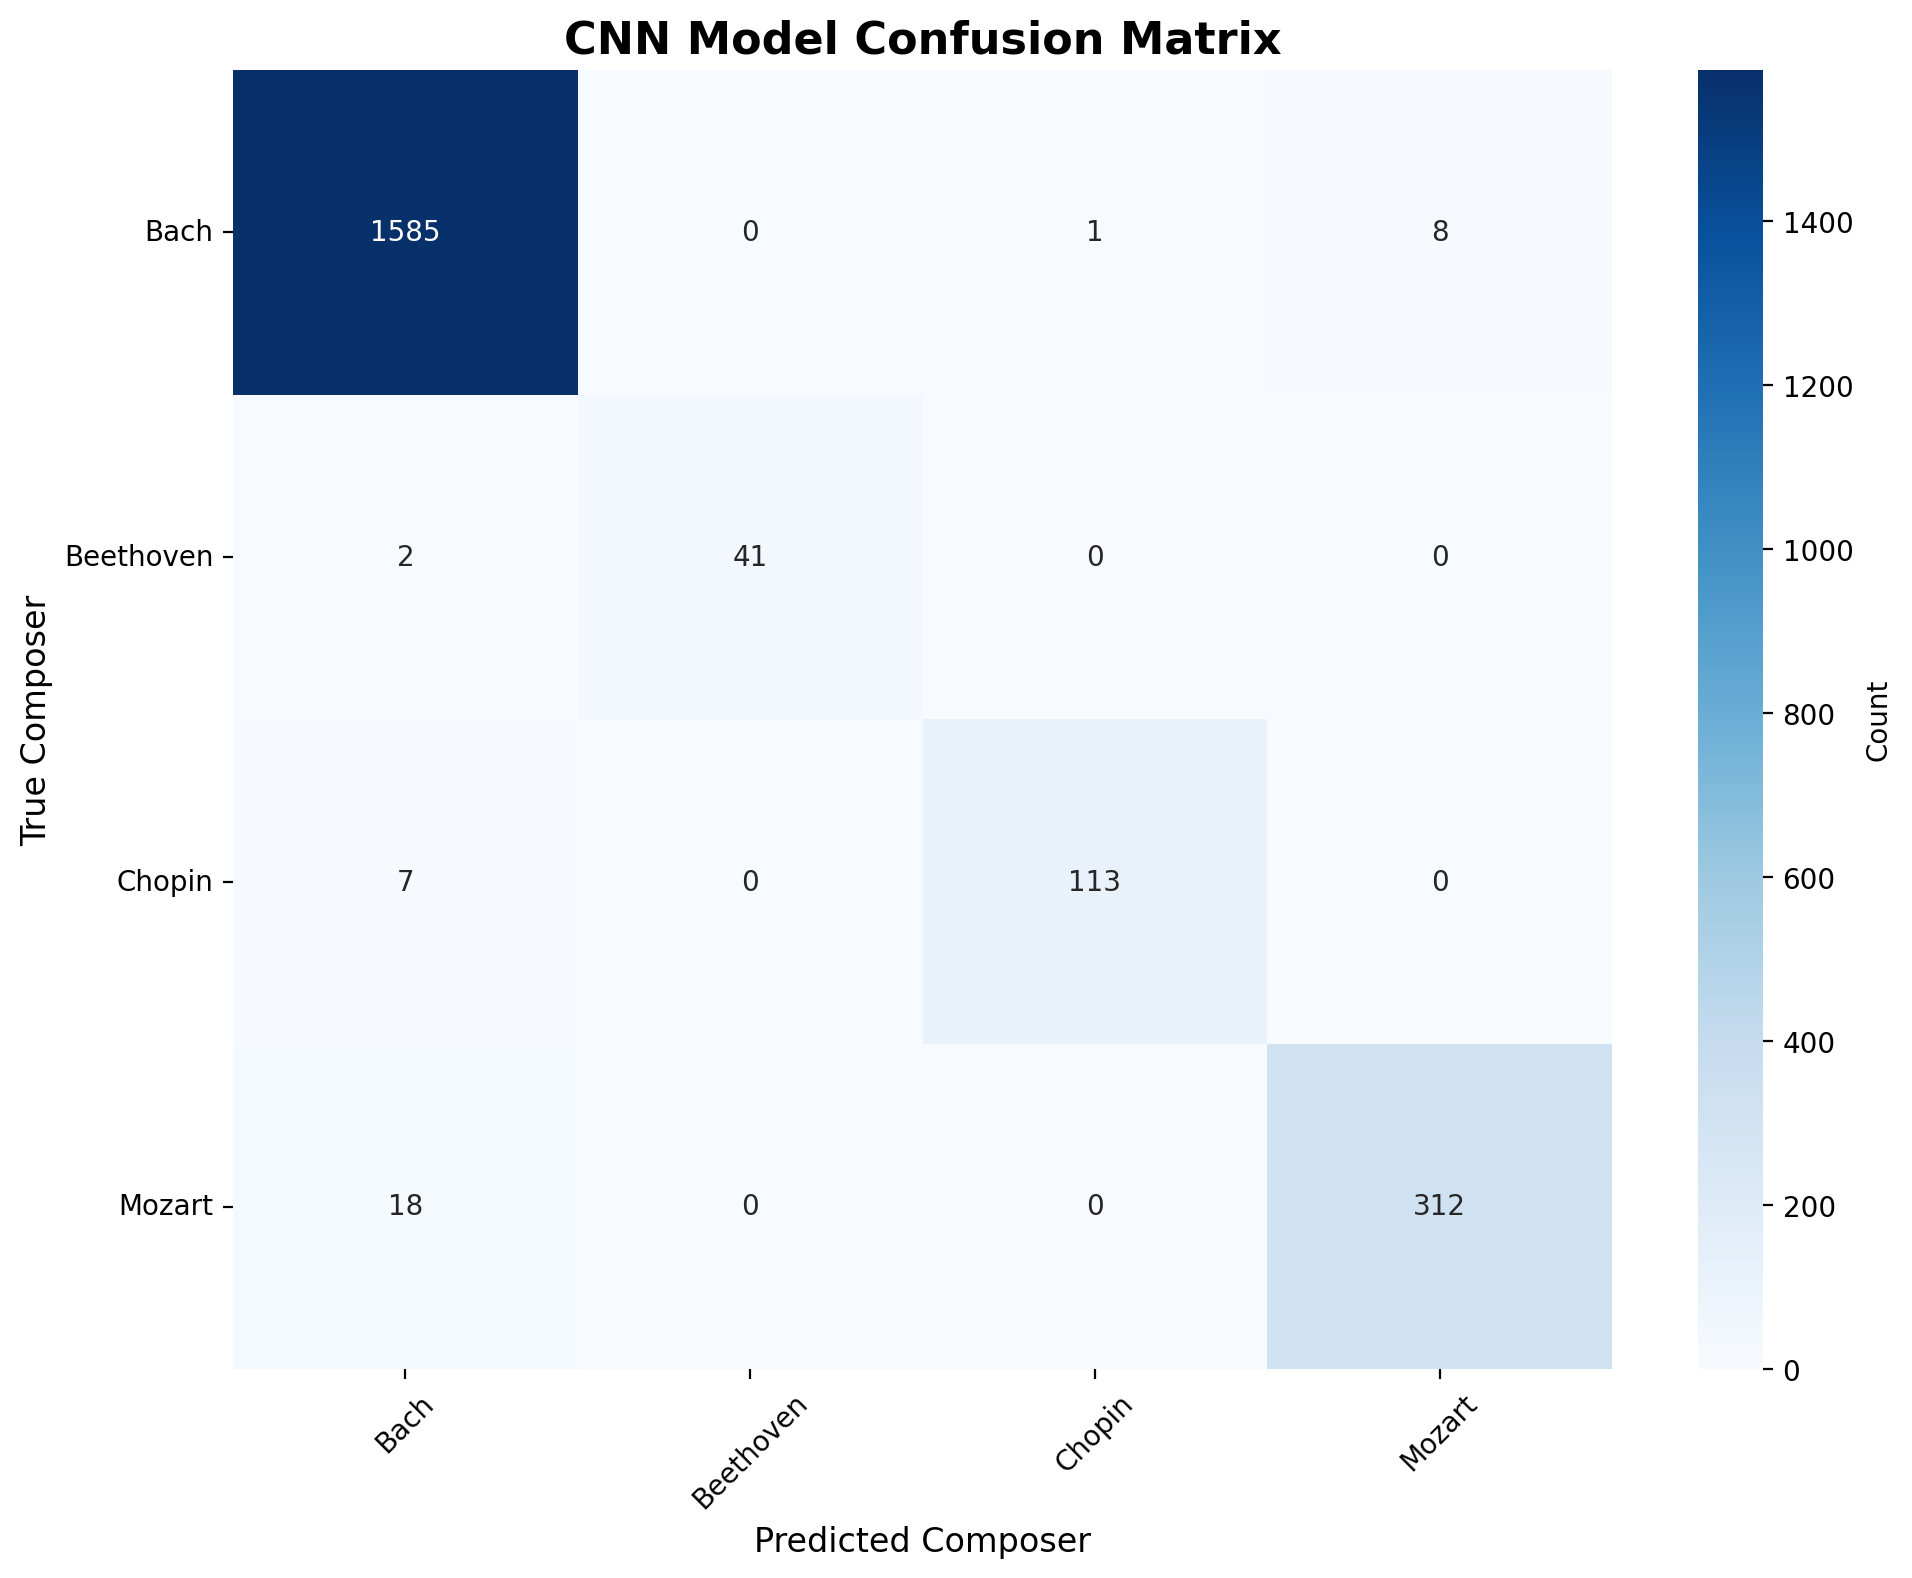

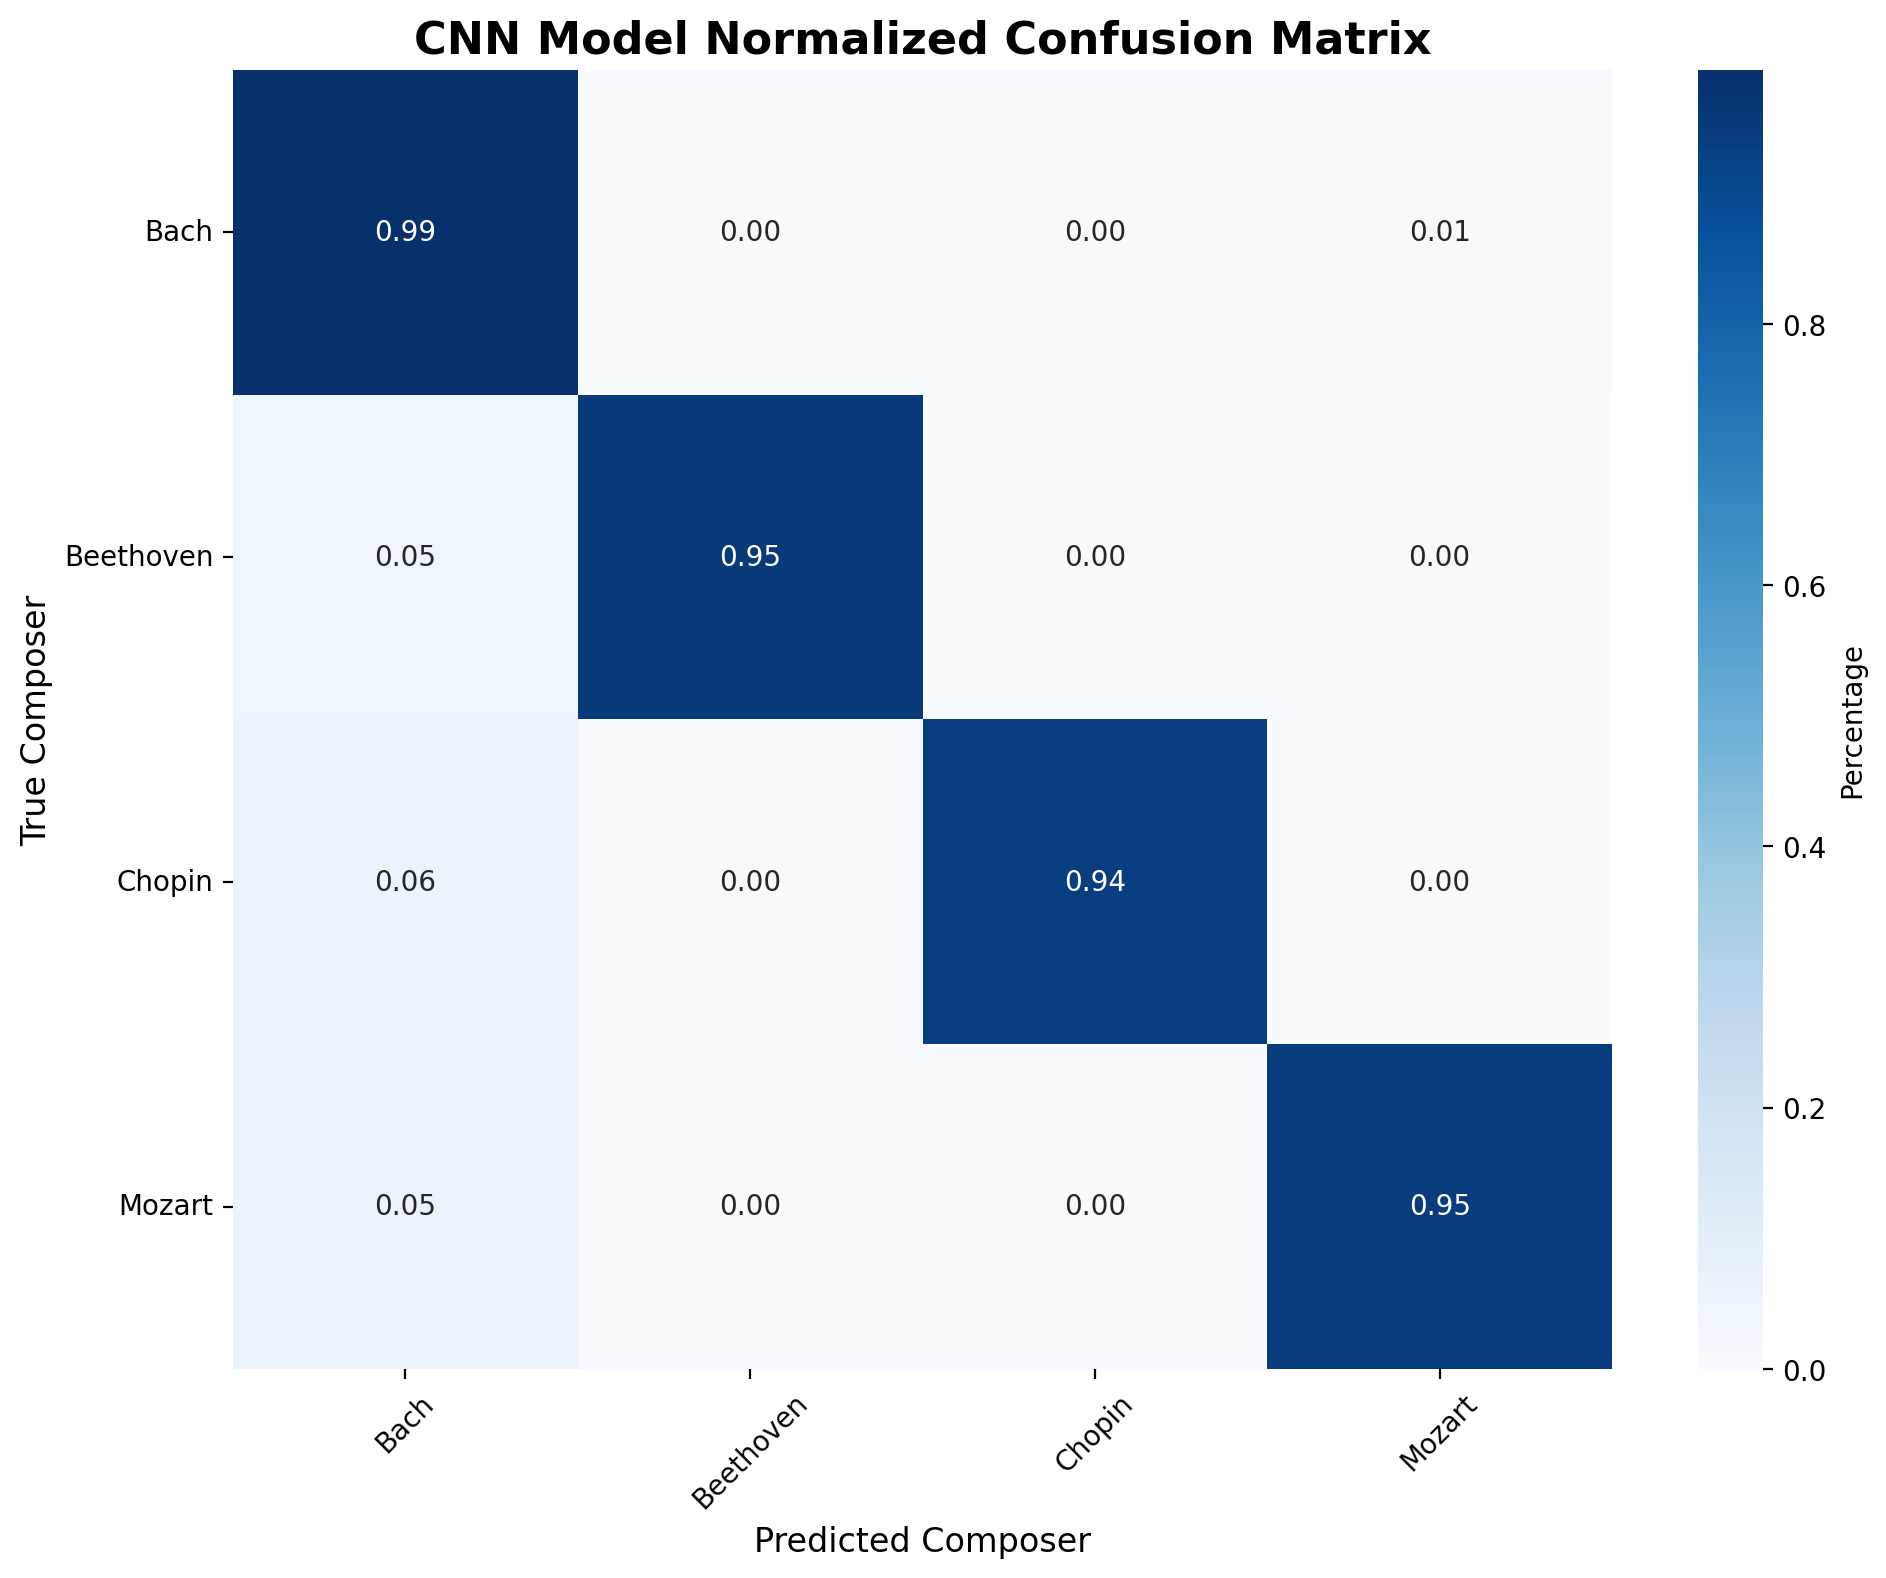

In [ ]:
# ------------------------------
# Confusion Matrix
# ------------------------------
plt.figure(figsize=(10, 8))

# Get unique classes present in the validation set
unique_labels = np.unique(np.concatenate([all_true_labels, all_predictions]))
actual_composer_names = [label_to_composer[i] for i in unique_labels]

print(f"Classes present in validation set: {unique_labels}")
print(f"Corresponding composers: {actual_composer_names}")

# Generate confusion matrix with all possible labels
cm = confusion_matrix(all_true_labels, all_predictions, labels=unique_labels)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=actual_composer_names, columns=actual_composer_names)

# Plot heatmap
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('CNN Model Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Composer', fontsize=12)
plt.ylabel('True Composer', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate and display normalized confusion matrix
plt.figure(figsize=(10, 8))
cm_normalized = confusion_matrix(all_true_labels, all_predictions, labels=unique_labels, normalize='true')
cm_norm_df = pd.DataFrame(cm_normalized, index=actual_composer_names, columns=actual_composer_names)

sns.heatmap(cm_norm_df, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Percentage'})
plt.title('CNN Model Normalized Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Composer', fontsize=12)
plt.ylabel('True Composer', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Bach       0.98      0.99      0.99      1594
   Beethoven       1.00      0.95      0.98        43
      Chopin       0.99      0.94      0.97       120
      Mozart       0.97      0.95      0.96       330

    accuracy                           0.98      2087
   macro avg       0.99      0.96      0.97      2087
weighted avg       0.98      0.98      0.98      2087



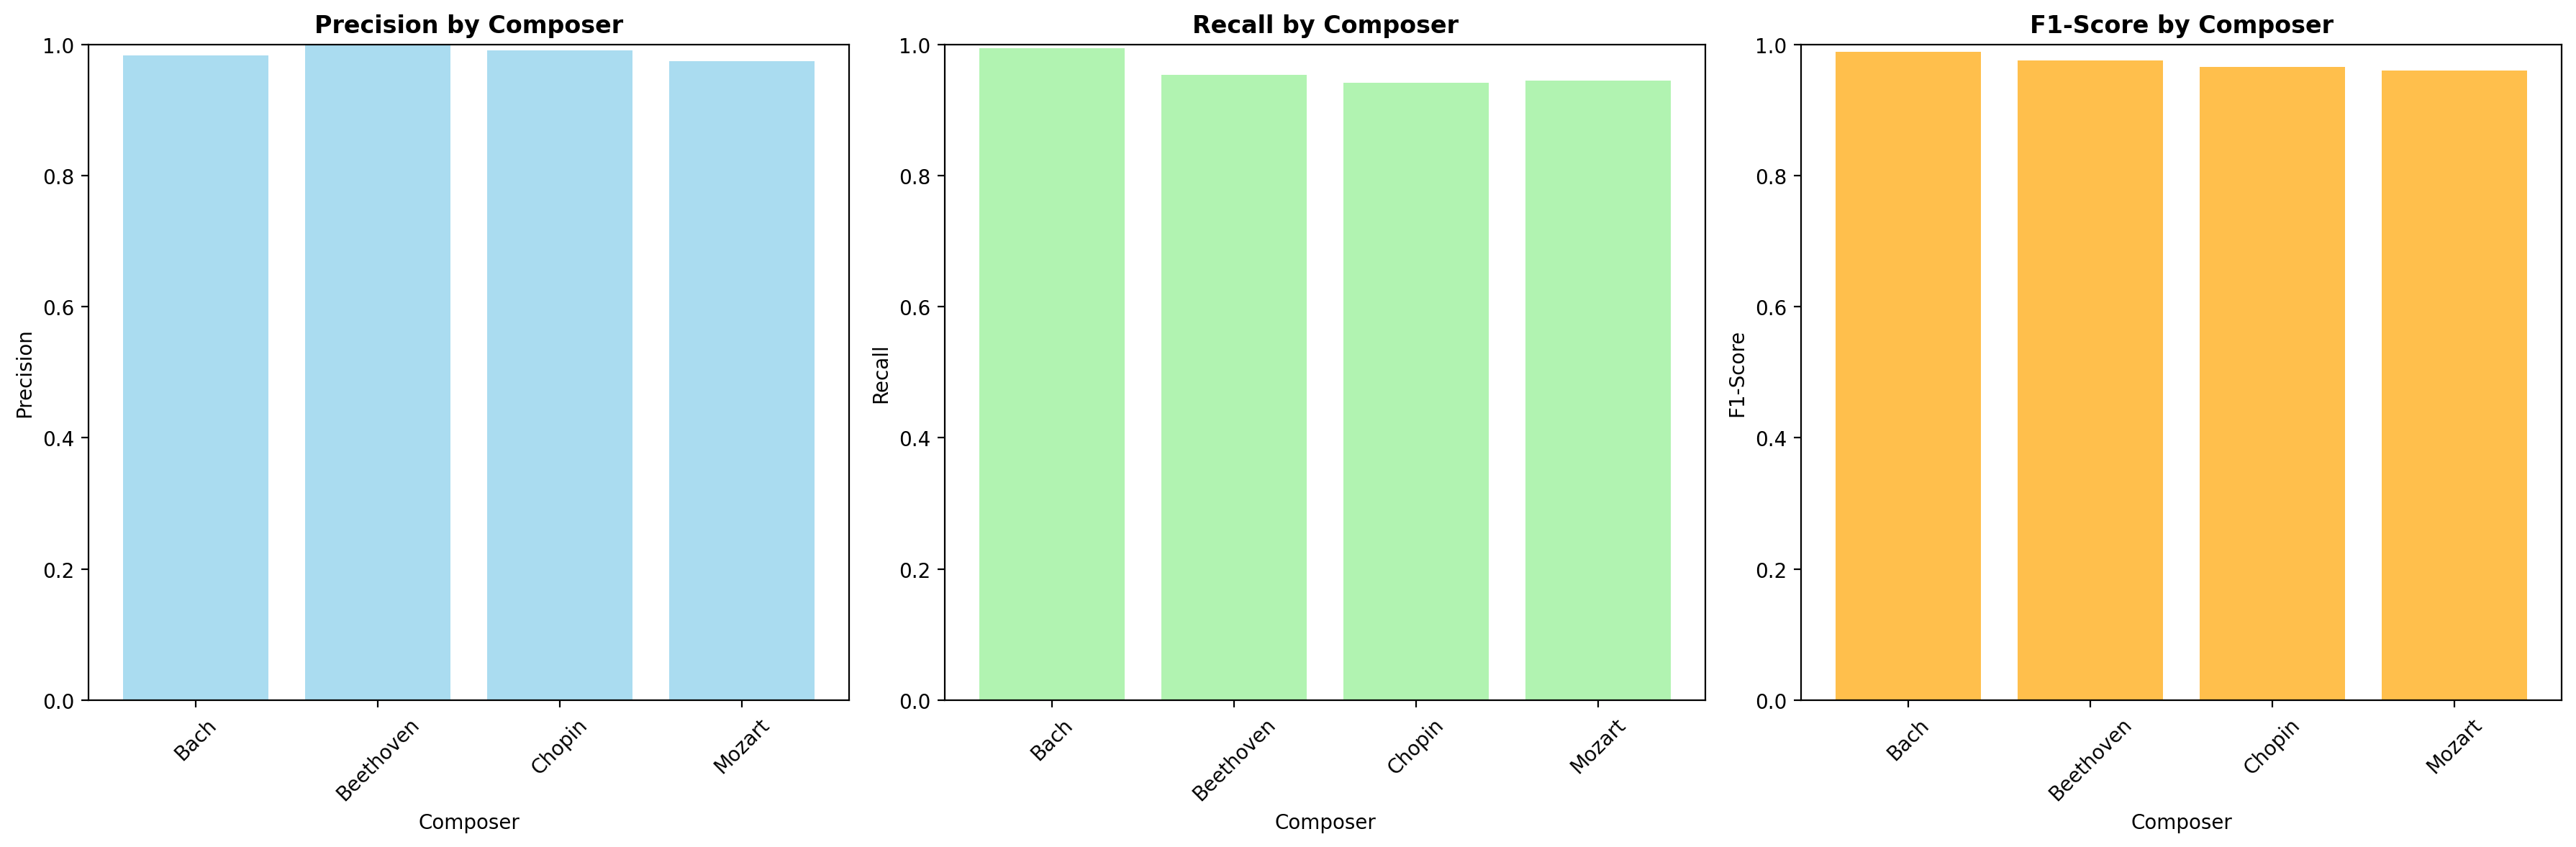


Overall Model Accuracy: 0.9828 (98.28%)


In [ ]:
# ------------------------------
# Classification Report and Metrics
# ------------------------------
print("=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)

# Generate classification report using only classes present in validation set
report = classification_report(all_true_labels, all_predictions, 
                             target_names=actual_composer_names,
                             labels=unique_labels,
                             output_dict=True)

# Display classification report
print(classification_report(all_true_labels, all_predictions, 
                          target_names=actual_composer_names,
                          labels=unique_labels))

# Create a DataFrame for metrics visualization
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.iloc[:-3, :-1]  # Remove avg rows and support column for plotting

# Plot per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].bar(range(len(actual_composer_names)), [report[name]['precision'] for name in actual_composer_names], 
           color='skyblue', alpha=0.7)
axes[0].set_title('Precision by Composer', fontweight='bold')
axes[0].set_xlabel('Composer')
axes[0].set_ylabel('Precision')
axes[0].set_xticks(range(len(actual_composer_names)))
axes[0].set_xticklabels(actual_composer_names, rotation=45)
axes[0].set_ylim(0, 1)

# Recall
axes[1].bar(range(len(actual_composer_names)), [report[name]['recall'] for name in actual_composer_names], 
           color='lightgreen', alpha=0.7)
axes[1].set_title('Recall by Composer', fontweight='bold')
axes[1].set_xlabel('Composer')
axes[1].set_ylabel('Recall')
axes[1].set_xticks(range(len(actual_composer_names)))
axes[1].set_xticklabels(actual_composer_names, rotation=45)
axes[1].set_ylim(0, 1)

# F1-Score
axes[2].bar(range(len(actual_composer_names)), [report[name]['f1-score'] for name in actual_composer_names], 
           color='orange', alpha=0.7)
axes[2].set_title('F1-Score by Composer', fontweight='bold')
axes[2].set_xlabel('Composer')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticks(range(len(actual_composer_names)))
axes[2].set_xticklabels(actual_composer_names, rotation=45)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Model Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

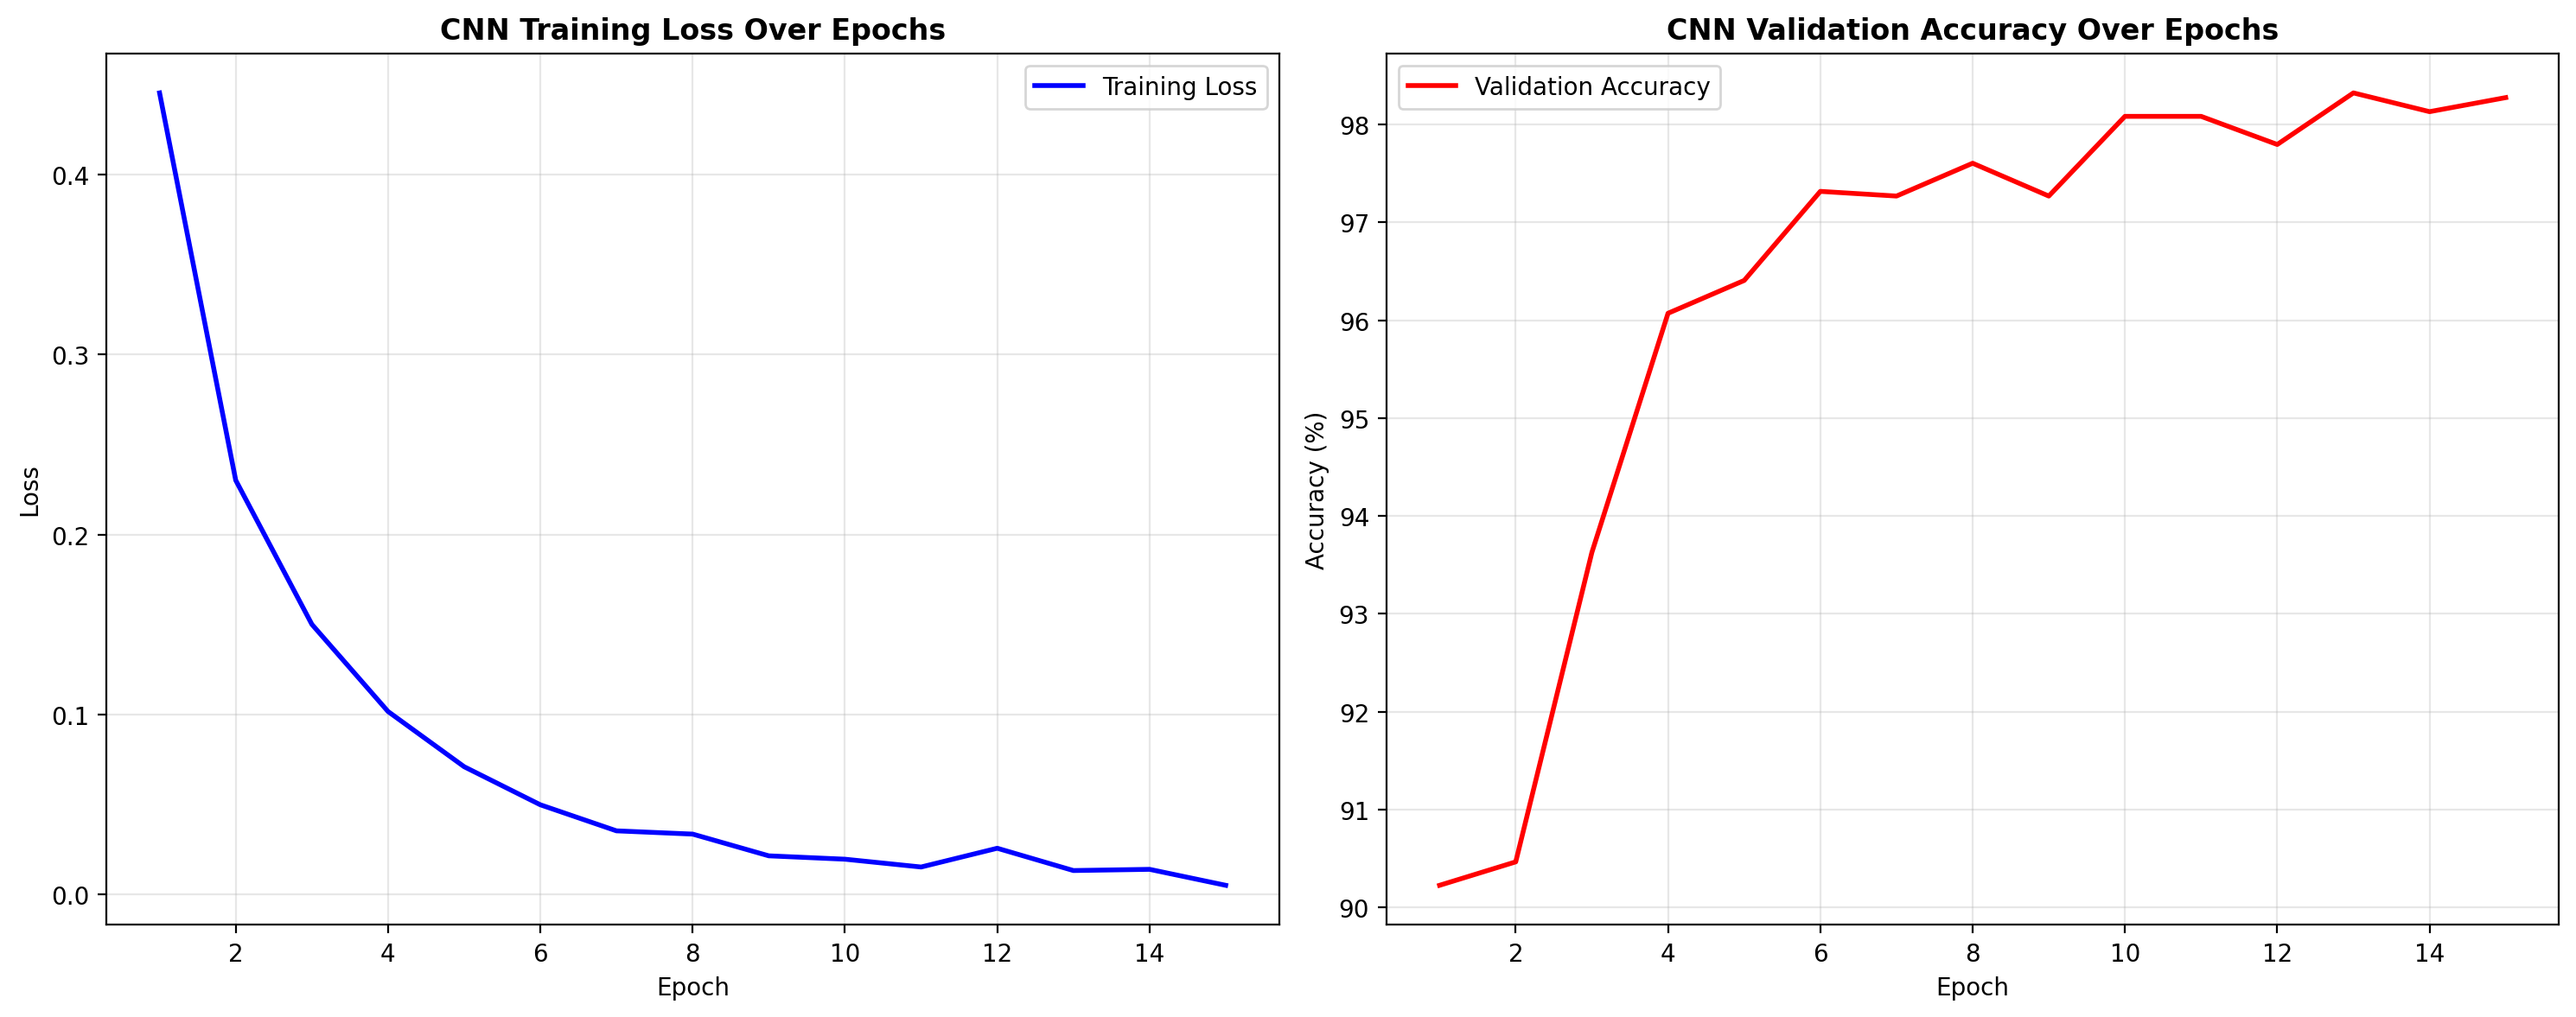

TRAINING SUMMARY
Total Epochs Trained: 15
Final Training Loss: 0.0052
Final Validation Accuracy: 98.28%
Best Validation Accuracy: 98.32%
Best Epoch: 13
✅ No significant overfitting detected


In [ ]:
# ------------------------------
# Training and Validation Curves
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Loss Curve
epochs_range = range(1, len(cnn_train_losses) + 1)
axes[0].plot(epochs_range, cnn_train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0].set_title('CNN Training Loss Over Epochs', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Validation Accuracy Curve
axes[1].plot(epochs_range, cnn_val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
axes[1].set_title('CNN Validation Accuracy Over Epochs', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Print training summary
print("=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Total Epochs Trained: {len(cnn_train_losses)}")
print(f"Final Training Loss: {cnn_train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {cnn_val_accuracies[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(cnn_val_accuracies):.2f}%")
print(f"Best Epoch: {cnn_val_accuracies.index(max(cnn_val_accuracies)) + 1}")

# Check for overfitting indicators
best_epoch = cnn_val_accuracies.index(max(cnn_val_accuracies)) + 1
final_epoch = len(cnn_val_accuracies)
if final_epoch - best_epoch > 5:
    print(f"⚠️  Potential overfitting detected: Best accuracy was at epoch {best_epoch}, but training continued to epoch {final_epoch}")
else:
    print("✅ No significant overfitting detected")

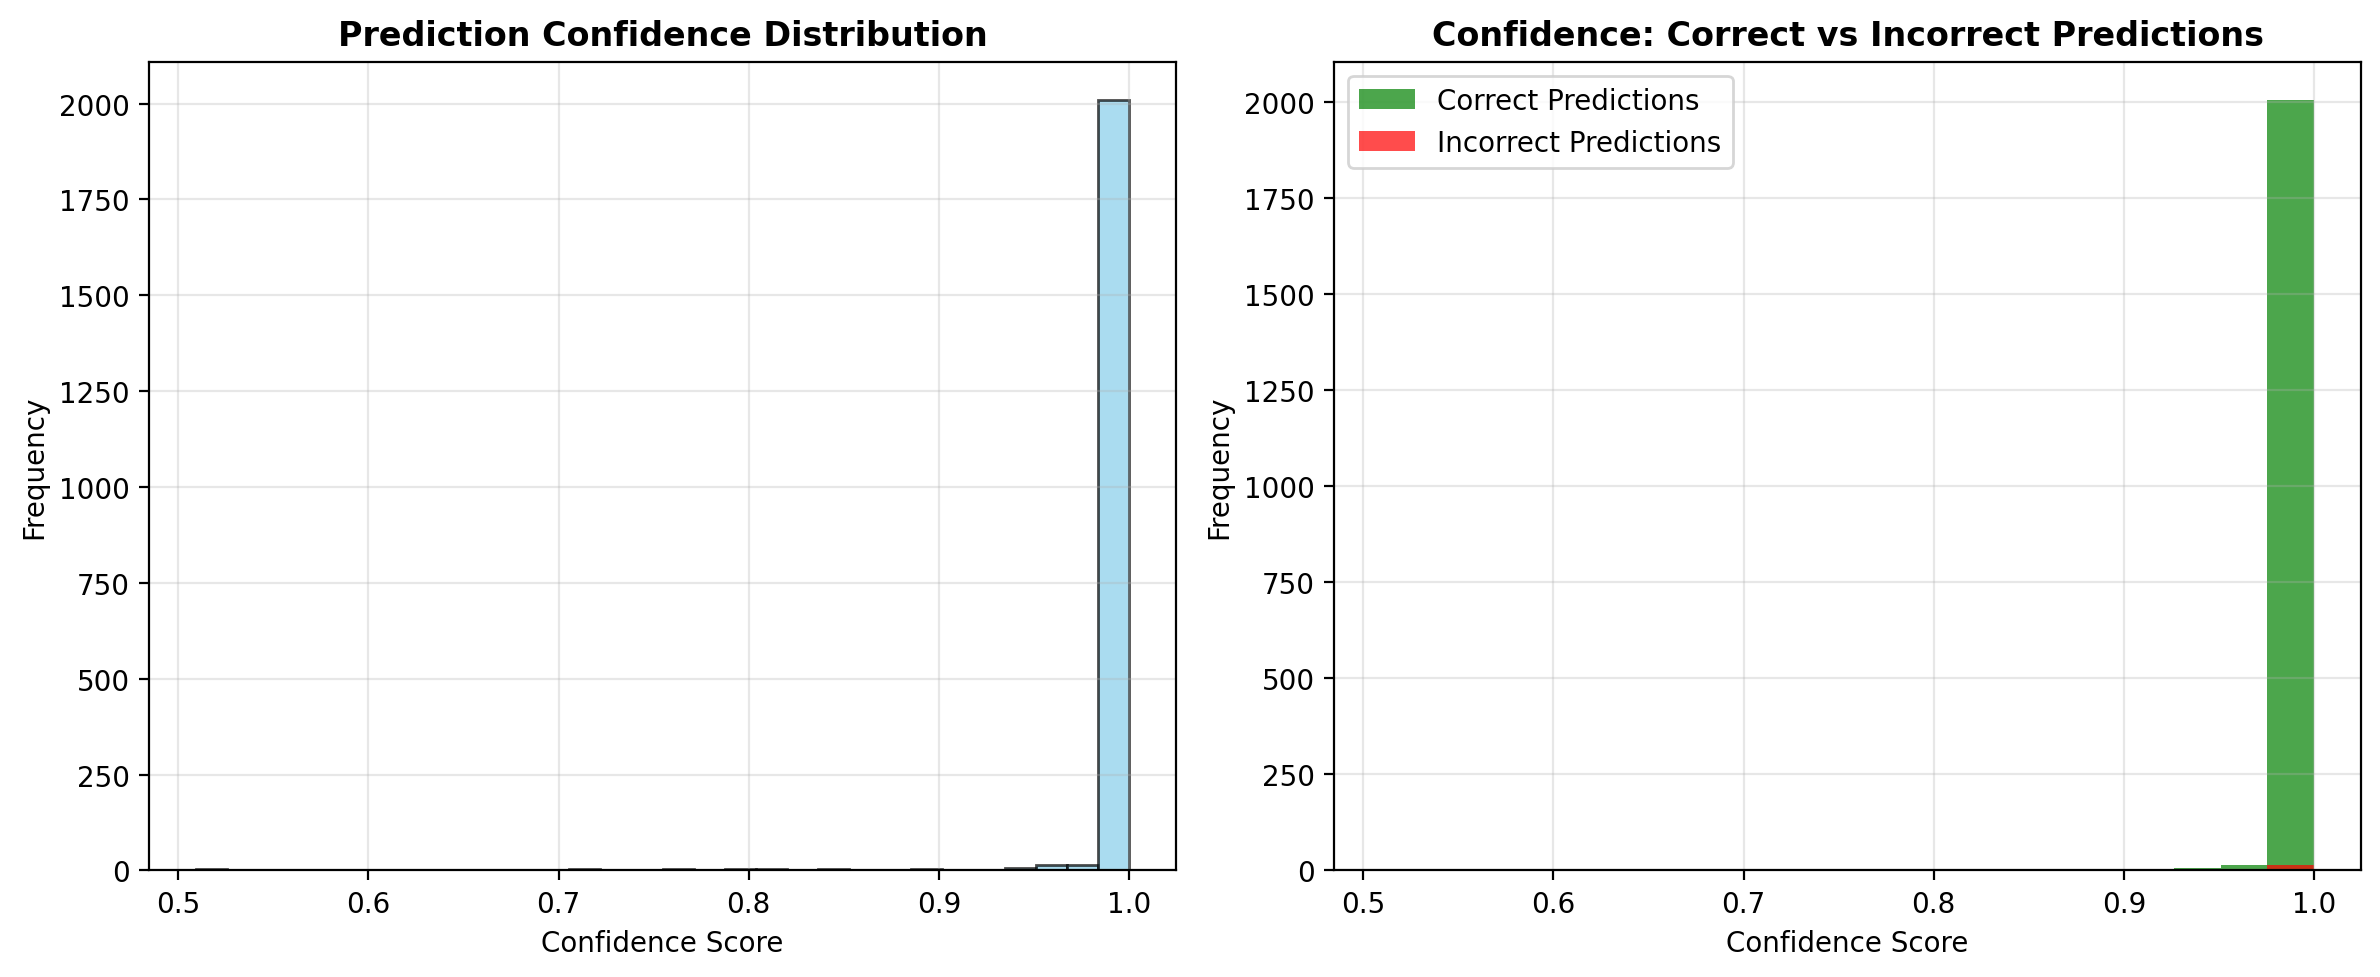

CONFIDENCE ANALYSIS
Average Confidence (All): 0.9940
Average Confidence (Correct): 0.9962
Average Confidence (Incorrect): 0.8733
High Confidence Predictions (>0.8): 2062 (98.8%)
Low Confidence Predictions (<0.5): 0 (0.0%)


In [ ]:
# ------------------------------
# Model Performance Analysis
# ------------------------------

# Analyze prediction confidence
model_cnn.eval()
confidence_scores = []
prediction_probabilities = []

with torch.no_grad():
    for X_val, y_val in cnn_val_loader:
        X_val = X_val.to(device)
        outputs = model_cnn(X_val)
        probabilities = torch.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probabilities, dim=1)
        
        confidence_scores.extend(max_probs.cpu().numpy())
        prediction_probabilities.extend(probabilities.cpu().numpy())

confidence_scores = np.array(confidence_scores)
prediction_probabilities = np.array(prediction_probabilities)

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Prediction Confidence Distribution', fontweight='bold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Correct vs Incorrect predictions confidence
correct_mask = (all_predictions == all_true_labels)
correct_confidence = confidence_scores[correct_mask]
incorrect_confidence = confidence_scores[~correct_mask]

plt.subplot(1, 2, 2)
plt.hist(correct_confidence, bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_confidence, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Confidence: Correct vs Incorrect Predictions', fontweight='bold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("CONFIDENCE ANALYSIS")
print("=" * 60)
print(f"Average Confidence (All): {np.mean(confidence_scores):.4f}")
print(f"Average Confidence (Correct): {np.mean(correct_confidence):.4f}")
print(f"Average Confidence (Incorrect): {np.mean(incorrect_confidence):.4f}")
print(f"High Confidence Predictions (>0.8): {np.sum(confidence_scores > 0.8)} ({np.sum(confidence_scores > 0.8)/len(confidence_scores)*100:.1f}%)")
print(f"Low Confidence Predictions (<0.5): {np.sum(confidence_scores < 0.5)} ({np.sum(confidence_scores < 0.5)/len(confidence_scores)*100:.1f}%)")

In [ ]:
# ------------------------------
# Error Analysis
# ------------------------------
print("=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

# Find misclassified examples
misclassified_indices = np.where(all_predictions != all_true_labels)[0]
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(all_predictions)}")

# Analyze confusion patterns using actual labels present
print("\nMost Common Misclassification Patterns:")
for true_label in unique_labels:
    for pred_label in unique_labels:
        if true_label != pred_label:
            count = np.sum((all_true_labels == true_label) & (all_predictions == pred_label))
            if count > 0:
                percentage = count / np.sum(all_true_labels == true_label) * 100
                if percentage > 10:  # Only show significant patterns
                    true_composer = label_to_composer[true_label]
                    pred_composer = label_to_composer[pred_label]
                    print(f"  {true_composer} → {pred_composer}: {count} times ({percentage:.1f}%)")

# Sample some misclassified examples
if len(misclassified_indices) > 0:
    print(f"\nSample Misclassified Examples:")
    sample_size = min(10, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)
    
    for i, idx in enumerate(sample_indices):
        true_composer = label_to_composer[all_true_labels[idx]]
        pred_composer = label_to_composer[all_predictions[idx]]
        confidence = confidence_scores[idx]
        print(f"  {i+1}. True: {true_composer}, Predicted: {pred_composer}, Confidence: {confidence:.3f}")

# ------------------------------
# Model Summary and Recommendations
# ------------------------------
print("\n" + "=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)

best_composer_idx = np.argmax([report[name]['f1-score'] for name in actual_composer_names])
worst_composer_idx = np.argmin([report[name]['f1-score'] for name in actual_composer_names])

print(f"📊 Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"🏆 Best Performing Composer: {actual_composer_names[best_composer_idx]} (F1: {report[actual_composer_names[best_composer_idx]]['f1-score']:.3f})")
print(f"⚠️  Worst Performing Composer: {actual_composer_names[worst_composer_idx]} (F1: {report[actual_composer_names[worst_composer_idx]]['f1-score']:.3f})")
print(f"📈 Training Epochs: {len(cnn_train_losses)}")
print(f"🎯 Best Validation Accuracy: {max(cnn_val_accuracies):.2f}%")

# Check which composers are missing from validation set
all_composer_names = [label_to_composer[i] for i in range(len(composer_to_label))]
missing_composers = set(all_composer_names) - set(actual_composer_names)
if missing_composers:
    print(f"⚠️  Missing composers in validation set: {', '.join(missing_composers)}")

print(f"\n💡 RECOMMENDATIONS:")
if overall_accuracy < 0.8:
    print("  • Consider training for more epochs or adjusting learning rate")
    print("  • Try data augmentation techniques or feature engineering")
    print("  • Experiment with different model architectures")
if max(cnn_val_accuracies) - cnn_val_accuracies[-1] > 5:
    print("  • Model may be overfitting - consider early stopping or regularization")
if np.mean(confidence_scores) < 0.7:
    print("  • Model predictions lack confidence - consider ensemble methods")
if missing_composers:
    print(f"  • Collect more data for missing composers: {', '.join(missing_composers)}")
print("  • Collect more training data for underperforming composers")
print("  • Analyze feature importance to understand model decisions")

ERROR ANALYSIS
Total misclassified samples: 36 out of 2087

Most Common Misclassification Patterns:

Sample Misclassified Examples:
  1. True: Mozart, Predicted: Bach, Confidence: 0.741
  2. True: Bach, Predicted: Chopin, Confidence: 0.802
  3. True: Mozart, Predicted: Bach, Confidence: 0.509
  4. True: Bach, Predicted: Mozart, Confidence: 0.956
  5. True: Mozart, Predicted: Bach, Confidence: 1.000
  6. True: Chopin, Predicted: Bach, Confidence: 0.972
  7. True: Mozart, Predicted: Bach, Confidence: 0.941
  8. True: Mozart, Predicted: Bach, Confidence: 1.000
  9. True: Bach, Predicted: Mozart, Confidence: 0.964
  10. True: Mozart, Predicted: Bach, Confidence: 0.570

MODEL PERFORMANCE SUMMARY
📊 Overall Accuracy: 98.28%
🏆 Best Performing Composer: Bach (F1: 0.989)
⚠️  Worst Performing Composer: Mozart (F1: 0.960)
📈 Training Epochs: 15
🎯 Best Validation Accuracy: 98.32%

💡 RECOMMENDATIONS:
  • Collect more training data for underperforming composers
  • Analyze feature importance to unders